# Garbage Collection

## Реализации Python

- CPython - основная
- IronPython (.net)
- Jython (JVM)
- PyPy

## Сборщик мусора

- не нужно думать о памяти: нет утечек
- нет double free ошибок


- дополнительное использование процессора и памяти
- очистка памяти в случайное время

## Сборщик мусора в Python

состоит из двух компонент:

1. Подсчет ссылок
2. Generative garbage collector

https://rushter.com/blog/python-garbage-collector/

## Reference counting

В Python для каждого объекта создается счетчик ссылок на него. Счетчик инкрементируется, когда в коде происходит:

- операция присваивания
- передача аргумента
- добавление объекта в коллекцию

In [1]:
import sys

sys.getrefcount("654321")

3

In [2]:
b = "654321"
sys.getrefcount("654321")

4

In [3]:
b = 1
sys.getrefcount("654321")

3

### Refcount и стек вызовов

Создадим обычный список. Сразу получим 1 ссылку на него - от переменной `foo`. Вторая ссылка появляется потому, что мы передаем `foo` как аргумент в `getrefcount`.

In [4]:
foo = []
sys.getrefcount(foo)

2

Внутри вызванной функции получим 2 дополнительные ссылки: из аргумента функции и из стека вызовов питона.

In [5]:
def bar(a):
    print(sys.getrefcount(a))
    
bar(foo)

sys.getrefcount(foo)

4


2

Подсчет ссылок влечет за собой следующие нюансы:

- память сразу можно очистить


- сложности при обработке циклических ссылок



- thread-lock
- затратно по ресурсам: в каждом прогоне сборщик мусора должен опросить каждый существующий объект

## Generative garbage collection

https://docs.microsoft.com/ru-ru/archive/blogs/abhinaba/back-to-basics-generational-garbage-collection

Из-за того, что простой подсчет ссылок не справляется с циклическими ссылками, в Python 1.5 был введен еще один подход к сборке мусора, который называется генеративной сборкой мусора. Он отслеживает только те объекты, которые могут ссылаться на что-то еще:

- коллекции
- классы

Простой случай: рассмотрим следующий граф ссылок на объекты.

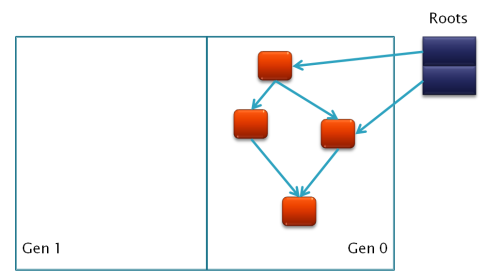

Допустим, после исполнения некоторого кода ссылка на верхний объект была удалена.

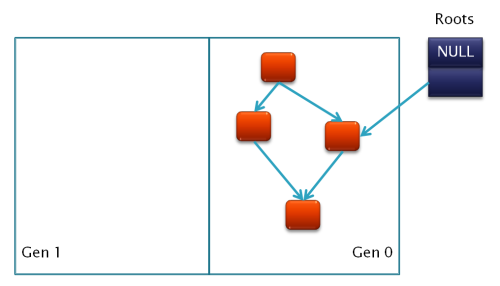

Через какое-то время сборщик мусора удалит верхний объект и все те, на которые он ссылается, если на них не ссылаются другие объекты.

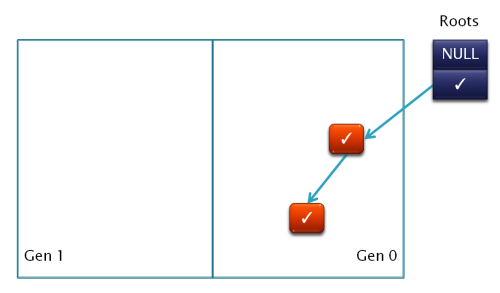

Когда количество оставшихся объектов превышает некоторый порог, они перемещаются в следующее "поколение" объектов. К каждому следующему поколению сборщик мусора обращается реже, чем к предыдущему.

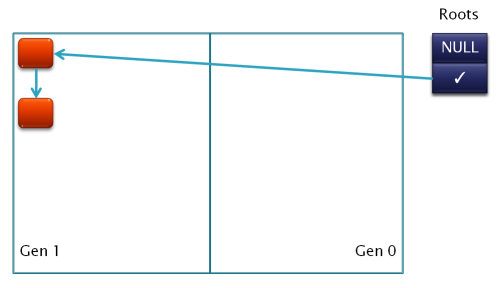

В Python есть модуль `gc`, который реализует взаимодействие в генеративным сборщиком мусора. Посмотреть, какой лимит на размер поколений задан в данный момент, можно так:

In [6]:
import gc

gc.get_threshold()

(700, 10, 10)

Аналогичная ситуация повторяется для вновь создаваемых объектов.

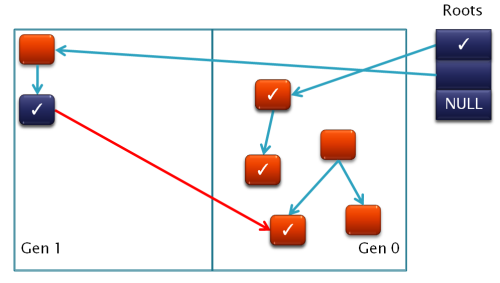

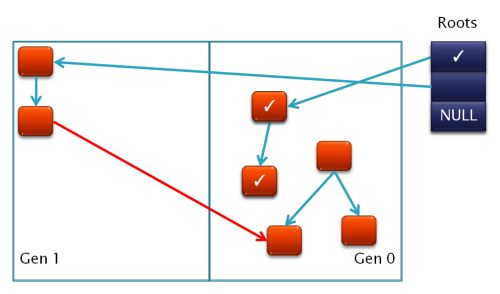

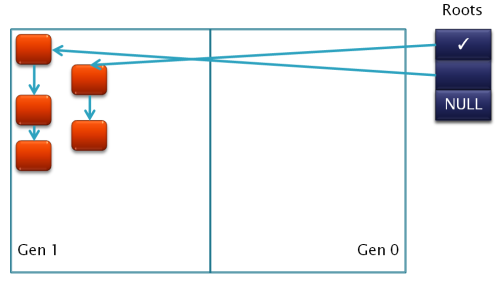

Посмотрим, что будет, если отключить gc:

In [7]:
import ctypes

# Обернем кусок C-шного класса в питоновскую оболочку, чтобы можно было к нему обратиться из кода
class PyObject(ctypes.Structure):
    _fields_ = [("refcnt", ctypes.c_long)]


gc.disable()  # отключаем генеративный сборщик мусора

# создадим циклическую ссылку
lst = []
lst.append(lst)

# сохраним адрес в памяти этого списка
lst_address = id(lst)

# удалим ссылку из переменной на этот список
del lst


# также создадим объекты с перекрестными ссылками
object_1 = {}
object_2 = {}
object_1['obj2'] = object_2
object_2['obj1'] = object_1

obj_address_1 = id(object_1)
obj_address_2 = id(object_2)

# удалим ссылки из переменных
del object_1, object_2

# посмотрим, сколько реально ссылок осталось на сохраненные адреса
print(PyObject.from_address(obj_address_1).refcnt)
print(PyObject.from_address(obj_address_2).refcnt)
print(PyObject.from_address(lst_address).refcnt)

1
1
1


In [8]:
object_1

NameError: name 'object_1' is not defined

In [9]:
# принудительно вызовем генеративный сборщик мусора
gc.collect()
print(PyObject.from_address(obj_address_1).refcnt)
print(PyObject.from_address(obj_address_2).refcnt)
print(PyObject.from_address(lst_address).refcnt)

0
0
0


## Weak reference

Слабые ссылки - это ссылки, которые не учитываются в счетчике ссылок. Иногда их можно использовать для экономии памяти, если внезапное исчезновение объекта не приведет ни к чему плохому по логике программы.

https://docs.python.org/3/library/weakref.html

In [10]:
import weakref
import gc

gc.collect()

class Class:
    def method(self):
        print("hi")


def callback(reference):
    print("object deleted:", reference)


def demonstrations():
    foo = Class()
    bar = weakref.ref(foo)
    bar_cb = weakref.ref(foo, callback)

    print("foo:", foo)
    print("bar:", bar)
    print("bar.method:", bar().method())
    bar().a = 5
    print("foo.a:", foo.a)
    print()
    del foo
    print("new bar:", bar())
    print("new bar with callback:", bar_cb())
    
demonstrations()

foo: <__main__.Class object at 0x7fc7786e88b0>
bar: <weakref at 0x7fc7786e4a40; to 'Class' at 0x7fc7786e88b0>
hi
bar.method: None
foo.a: 5

object deleted: <weakref at 0x7fc758132270; dead>
new bar: None
new bar with callback: None


Также этот модуль включает в себя ряд вспомогательных классов, например:

In [11]:
def weak_method_demo():
    class C:
        def method(self):
            print("method called!")

    c = C()
    r = weakref.ref(c.method)
    print("usual ref:", r())
    r = weakref.WeakMethod(c.method)
    print("weak method:", r())

    print("executing weak method:")
    r()()

    del c
    gc.collect()

    print("after del:", r())
    
weak_method_demo()

usual ref: None
weak method: <bound method weak_method_demo.<locals>.C.method of <__main__.weak_method_demo.<locals>.C object at 0x7fc7501d8400>>
executing weak method:
method called!
after del: None
